### Members' Full name:

- Nguyen Mai Dinh, Le - 300312139
- Ruiz, Ricardo - 300387021
- Jimmy, Suwarly - 300361475
- Hugh, Tran - 300394597

### References:
- CSIS 3400 – 070: Natural Language Processing CRN 17613 Lab 2 – Natural Language Processing & Text Classification
- CSIS 3400 – 070: Natural Language Processing CRN 17613 Lab 3 – Text Representation Lab 3 
- CSIS 3290 Introduction to Machine Learning Courseworks

# Part B. Basic Model

## Imported Libraries

In [1]:
### Import any necessary libraries here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import itertools
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import clone
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data exploration, pre-processing and cleansing (Jimmy)

### 1. Load Datasets

In [2]:
# Load the training and test datasets
train_data = pd.read_csv('climate_train.csv')
test_data = pd.read_csv('climate_test.csv')

# Display basic information about the datasets
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (1000, 3)
Test data shape: (320, 3)


### 2. Data Exploration

In [3]:
# Column names and data types
train_data.info()

# Preview data
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   text        1000 non-null   object
 2   label       1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


,Unnamed: 0,text,label
0,0,− Scope 3: Optional scope that includes indire...,0
1,1,The Group is not aware of any noise pollution ...,0
2,2,Global climate change could exacerbate certain...,0
3,3,Setting an investment horizon is part and parc...,1
4,4,Climate change the physical impacts of climate...,0


In [4]:
print("Missing values:\n", train_data.isnull().sum())
print("Duplicate rows:", train_data.duplicated().sum())

Missing values:
 Unnamed: 0    0
text          0
label         0
dtype: int64
Duplicate rows: 0


**Observation**: The dataset contains no missing values in both the text and label columns, and no duplicate rows were found.

In [5]:
train_data['label'].value_counts()

label
0    575
1    425
Name: count, dtype: int64

In [6]:
train_data['text_length'] = train_data['text'].apply(lambda x: len(x.split()))
train_data['text_length'].describe()

count    1000.000000
mean       72.224000
std        40.084918
min        16.000000
25%        50.000000
50%        63.000000
75%        83.000000
max       452.000000
Name: text_length, dtype: float64

**Observation**: The training dataset contains 1,000 text samples. On average, each document has approximately 72 words, with a median length of 63 words, indicating a moderate text size. Most texts fall between 50 and 83 words (25th–75th percentile), while a small number of longer documents extend up to 452 words, showing some variability. This variation suggests that normalization and feature scaling methods such as TF-IDF are appropriate for handling differences in document length.

### 3. Data Preprocessing

#### 3.1. Word Tokenization

In [7]:
# Tokenize training text 
train_data['tokens'] = train_data['text'].apply( lambda x: word_tokenize(x.lower()) ) 
# Tokenize test text 
test_data['tokens'] = test_data['text'].apply( lambda x: word_tokenize(x.lower()) ) 

# Display one example 
print("Original text:") 
print(train_data['text'].iloc[0]) 
print("\nTokenized text:") 
print(train_data['tokens'].iloc[0])

Original text:
− Scope 3: Optional scope that includes indirect emissions associated with the goods and services supply chain produced outside the organization. Included are emissions from the transport of products from our logistics centres to stores (downstream) performed by external logistics operators (air, land and sea transport) as well as the emissions associated with electricity consumption in franchise stores.

Tokenized text:
['−', 'scope', '3', ':', 'optional', 'scope', 'that', 'includes', 'indirect', 'emissions', 'associated', 'with', 'the', 'goods', 'and', 'services', 'supply', 'chain', 'produced', 'outside', 'the', 'organization', '.', 'included', 'are', 'emissions', 'from', 'the', 'transport', 'of', 'products', 'from', 'our', 'logistics', 'centres', 'to', 'stores', '(', 'downstream', ')', 'performed', 'by', 'external', 'logistics', 'operators', '(', 'air', ',', 'land', 'and', 'sea', 'transport', ')', 'as', 'well', 'as', 'the', 'emissions', 'associated', 'with', 'electric

#### 3.2. Stop word Removal

In [8]:
stop_words = set(stopwords.words('english'))

# Remove stop words from training tokens
train_data['clean_tokens'] = train_data['tokens'].apply(
    lambda tokens: [w for w in tokens if w not in stop_words and w.isalpha()]
)

# Remove stop words from test tokens
test_data['clean_tokens'] = test_data['tokens'].apply(
    lambda tokens: [w for w in tokens if w not in stop_words and w.isalpha()]
)

# Display one example
print("Tokenized text:")
print(train_data['tokens'].iloc[0])

print("\nAfter stop word removal:")
print(train_data['clean_tokens'].iloc[0])

Tokenized text:
['−', 'scope', '3', ':', 'optional', 'scope', 'that', 'includes', 'indirect', 'emissions', 'associated', 'with', 'the', 'goods', 'and', 'services', 'supply', 'chain', 'produced', 'outside', 'the', 'organization', '.', 'included', 'are', 'emissions', 'from', 'the', 'transport', 'of', 'products', 'from', 'our', 'logistics', 'centres', 'to', 'stores', '(', 'downstream', ')', 'performed', 'by', 'external', 'logistics', 'operators', '(', 'air', ',', 'land', 'and', 'sea', 'transport', ')', 'as', 'well', 'as', 'the', 'emissions', 'associated', 'with', 'electricity', 'consumption', 'in', 'franchise', 'stores', '.']

After stop word removal:
['scope', 'optional', 'scope', 'includes', 'indirect', 'emissions', 'associated', 'goods', 'services', 'supply', 'chain', 'produced', 'outside', 'organization', 'included', 'emissions', 'transport', 'products', 'logistics', 'centres', 'stores', 'downstream', 'performed', 'external', 'logistics', 'operators', 'air', 'land', 'sea', 'transport'

#### 3.3. Lemmatization

In [9]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_with_pos(tokens):
    pos_tags = nltk.pos_tag(tokens)
    return [lemmatizer.lemmatize(w, get_wordnet_pos(tag)) for w, tag in pos_tags]

train_data['lemmatized_tokens'] = train_data['clean_tokens'].apply(lemmatize_with_pos)
test_data['lemmatized_tokens']  = test_data['clean_tokens'].apply(lemmatize_with_pos)

print("After stop word removal:")
print(train_data['clean_tokens'].iloc[0])

print("\nAfter lemmatization (with POS):")
print(train_data['lemmatized_tokens'].iloc[0])

After stop word removal:
['scope', 'optional', 'scope', 'includes', 'indirect', 'emissions', 'associated', 'goods', 'services', 'supply', 'chain', 'produced', 'outside', 'organization', 'included', 'emissions', 'transport', 'products', 'logistics', 'centres', 'stores', 'downstream', 'performed', 'external', 'logistics', 'operators', 'air', 'land', 'sea', 'transport', 'well', 'emissions', 'associated', 'electricity', 'consumption', 'franchise', 'stores']

After lemmatization (with POS):
['scope', 'optional', 'scope', 'include', 'indirect', 'emission', 'associate', 'good', 'service', 'supply', 'chain', 'produce', 'outside', 'organization', 'include', 'emission', 'transport', 'product', 'logistics', 'centre', 'store', 'downstream', 'perform', 'external', 'logistics', 'operator', 'air', 'land', 'sea', 'transport', 'well', 'emission', 'associate', 'electricity', 'consumption', 'franchise', 'store']


In [10]:
def extra_clean_text(text):
    text = re.sub(r"http\S+|www\.\S+", " ", text)   # remove URLs
    text = re.sub(r"\bhttp\b", " ", text)          # remove standalone "http"
    text = re.sub(r"\s+", " ", text).strip()       # tidy spaces
    return text
train_data['final_text'] = train_data['lemmatized_tokens'].apply(lambda x: ' '.join(x))
test_data['final_text']  = test_data['lemmatized_tokens'].apply(lambda x: ' '.join(x))
train_data["final_text"] = train_data["final_text"].apply(extra_clean_text)
test_data["final_text"]  = test_data["final_text"].apply(extra_clean_text)

## Feature generation with TF-IDF

we converted our cleaned text data into numerical features that machine learning algorithms can process. We'll use the Term Frequency-Inverse Document Frequency (TF-IDF) technique, which is particularly effective for text classification tasks.


In [11]:
### THIS CODE BLOCK IS FOR FINE TUNING
# from sklearn.feature_extraction.text import TfidfTransformer


# X_train_text = train_data["final_text"]
# X_test_text  = test_data["final_text"]
# y_train = train_data["label"]
# y_test  = test_data["label"]

# # Search space
# ngram_settings = [(1,1), (1,2), (1,3)]
# max_features_list = [3000, 5000, 8000, 10000, 12000]
# min_df_list = [1, 2, 3, 4, 5]
# alphas = np.logspace(-2, 1, 20)

# # TF-IDF weighting options (optional but useful)
# use_idf_list = [True]
# sublinear_tf_list = [False, True]  # try log(1+tf)
# norm_list = ["l2", None]

# results = []

# for ngram_range in ngram_settings:
#     for max_feat in max_features_list:
#         for min_df in min_df_list:

#             # 1) BoW (counts)
#             bow_vec = CountVectorizer(
#                 max_features=max_feat,
#                 min_df=min_df,
#                 ngram_range=ngram_range
#             )
#             X_train_bow = bow_vec.fit_transform(X_train_text)
#             X_test_bow  = bow_vec.transform(X_test_text)

#             for use_idf in use_idf_list:
#                 for sublinear_tf in sublinear_tf_list:
#                     for norm in norm_list:

#                         # 2) TF-IDF weighting on top of BoW
#                         tfidf_trans = TfidfTransformer(
#                             use_idf=use_idf,
#                             sublinear_tf=sublinear_tf,
#                             norm=norm
#                         )
#                         X_train_tfidf = tfidf_trans.fit_transform(X_train_bow)
#                         X_test_tfidf  = tfidf_trans.transform(X_test_bow)

#                         # 3) Tune alpha for NB
#                         for a in alphas:
#                             nb = MultinomialNB(alpha=a)
#                             nb.fit(X_train_tfidf, y_train)

#                             y_pred = nb.predict(X_test_tfidf)
#                             acc = accuracy_score(y_test, y_pred)
#                             f1m = f1_score(y_test, y_pred, average="micro")

#                             results.append({
#                                 "ngram_range": str(ngram_range),
#                                 "max_features": max_feat,
#                                 "min_df": min_df,
#                                 "sublinear_tf": sublinear_tf,
#                                 "norm": str(norm),
#                                 "alpha": a,
#                                 "vocab_size": len(bow_vec.get_feature_names_out()),
#                                 "accuracy": acc,
#                                 "f1_micro": f1m
#                             })

# results_df_tfidf = (
#     pd.DataFrame(results)
#       .sort_values("f1_micro", ascending=False)
#       .reset_index(drop=True)
# )

# results_df_tfidf.head(5)

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer


X_train_text = train_data["final_text"]
X_test_text  = test_data["final_text"]
y_train = train_data["label"]
y_test  = test_data["label"]
bow_vec = CountVectorizer(
    ngram_range=(1, 3),
    max_features=5000,
    min_df=2
)

X_train_bow = bow_vec.fit_transform(X_train_text)
X_test_bow  = bow_vec.transform(X_test_text)

# =========================
# 2) TF-IDF Transformer (BEST)
# =========================
tfidf_trans = TfidfTransformer(
    use_idf=True,
    sublinear_tf=False,
    norm="l2"
)

X_train_tfidf = tfidf_trans.fit_transform(X_train_bow)
X_test_tfidf  = tfidf_trans.transform(X_test_bow)

# =========================
# 3) MultinomialNB (BEST)
# =========================
nb_final = MultinomialNB(alpha=1.623777)
nb_final.fit(X_train_tfidf, y_train)

# =========================
# 4) Evaluation
# =========================
y_pred = nb_final.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_macro = f1_score(y_test, y_pred, average="macro")

print("Final Model Performance")
print("-----------------------")
print(f"Accuracy   : {acc:.4f}")
print(f"F1-micro   : {f1_micro:.4f}")
print(f"F1-macro   : {f1_macro:.4f}")

Final Model Performance
-----------------------
Accuracy   : 0.8219
F1-micro   : 0.8219
F1-macro   : 0.7847


**Observation:** The presence of uncommon or domain-specific terms among the highest IDF words is expected. These words occur in very few documents, making them highly distinctive. While such terms can enhance class separation, they may also introduce noise if they are overly specific or context-dependent.

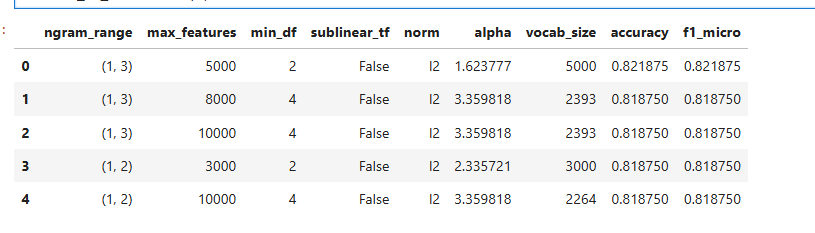

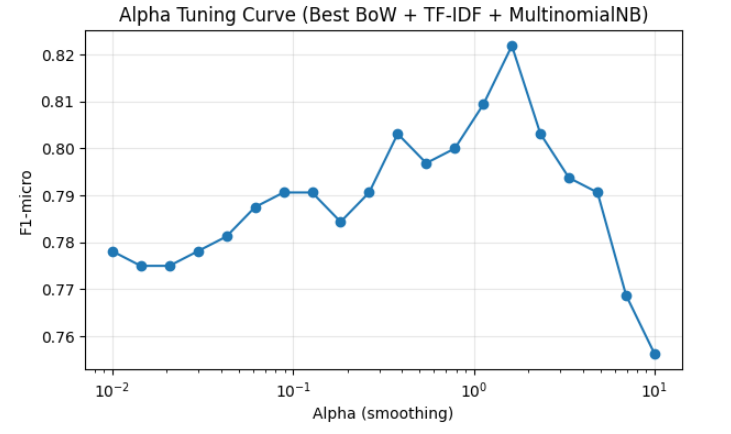


## 1. Pipeline Explanation

The objective of this pipeline is to build and optimize a document-level text classification model using classical NLP techniques.

### Step 1: Text Pre-processing

The raw climate-related documents were pre-processed through tokenization, stop-word removal, and lemmatization.
This step reduces noise, normalizes word forms, and ensures that semantically similar words (e.g., emissions and emission) are treated consistently.

### Step 2: Feature Generation (BoW + TF-IDF)

* Bag-of-Words (BoW) was first applied using CountVectorizer to convert documents into numerical vectors based on term frequencies. n-grams (up to trigrams) were included to capture multi-word expressions such as climate change, physical risk, and greenhouse gas, which are highly informative in climate-related text.

* TF-IDF weighting was then applied to rescale the BoW features. This down-weights very frequent but less informative terms and emphasizes more discriminative words and phrases.

### Step 3: Model Selection – Multinomial Naïve Bayes

Multinomial Naïve Bayes was selected because it is:

* Well-suited for discrete text features (term counts / TF-IDF),
* Computationally efficient,
* A strong baseline model for document classification tasks.

By combining Bag-of-Words with TF-IDF weighting, higher-order n-grams, and optimized Naïve Bayes smoothing, the final model achieves an F1-micro score of approximately 0.82, indicating effective and robust document-level classification performance.